# Hypothesis Testing Workshop

In the following exercises we will use the data of the teaching session, the **absolute magnitudes** (*2MASS* $K_s$-band) of **Galactic** globular clusters.

We will also load a new dataset containing the **apparent magnitudes** (in the same band) of globular clusters in the ** *Andromeda Galaxy* (M31)**.

Let's load the packages and data that are necessary for the exercises.

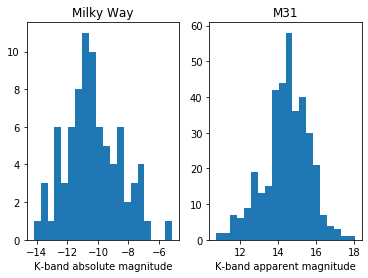

In [1]:
%matplotlib inline

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

absolute_MWG = np.loadtxt("data/GC_MWG_absolute.dat")
apparent_M31 = np.loadtxt("data/GC_M31_apparent.dat")

plt.figure()
plt.subplot(121)
plt.title("Milky Way")
plt.hist(absolute_MWG, bins=20)
plt.xlabel("K-band absolute magnitude")

plt.subplot(122)
plt.title("M31")
plt.hist(apparent_M31, bins=20)
plt.xlabel("K-band apparent magnitude")
plt.show()

# Exercise 1: distribution of M31 globular clusters

## (a) Is the M31 data normally distributed? 

Use **at least two different parametric tests** from `scipy.stats` https://docs.scipy.org/doc/scipy/reference/stats.html.
You can try the `shapiro` or `normaltest` methods.

In [2]:
# 1st test
_, pvalue = st.shapiro(apparent_M31)
print("p-value: {:.3g}".format(pvalue))

alpha = 0.05
if pvalue < alpha:
    print("It is not normally distributed.")
else:
    print("It is normally distributed.")

p-value: 0.00102
It is not normally distributed.


In [3]:
# 2nd test
_, pvalue = st.normaltest(apparent_M31)
print("p-value: {:.3g}".format(pvalue))

alpha = 0.05
if pvalue < alpha:
    print("It is not normally distributed.")
else:
    print("It is normally distributed.")

p-value: 0.00414
It is not normally distributed.


## (b) Test the normality of the M31 data using the Kolmogorov-Smirnov test.

* Use the K-S test to test for normality. What is your choice for the location and scale of the Gaussian distribution you test the data against?

* What is the outcome?

In [4]:
mean = np.mean(apparent_M31)
std = np.std(apparent_M31)
dist = st.norm(loc=mean, scale=std)
_, pvalue = st.kstest(apparent_M31, dist.cdf)
print("p-value: {:.3g}".format(pvalue))

alpha = 0.05
if pvalue < alpha:
    print("It is not normally distributed.")
else:
    print("It is normally distributed.")

p-value: 0.108
It is normally distributed.


## (c) EXTRA CREDIT: shortcoming of the K-S test

* Why is the $p$-value large in the case of Kolmogorov-Smirnov test? What is the weakness of the K-S test?

* In the following code block, we plot the empirical/theoretical PDFs and CDFs. Any clues from that?

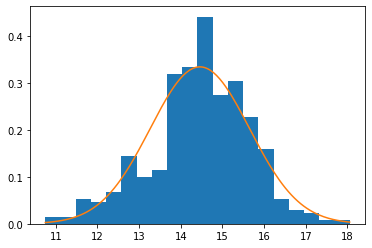

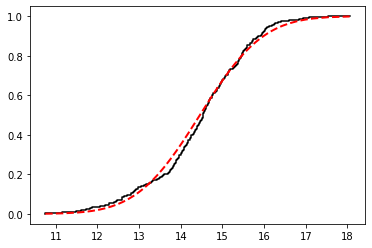

In [5]:
# Let's look at the empirical PDF and the normal approximation superposed...
x_values = np.linspace(min(apparent_M31), max(apparent_M31), 200)
plt.figure()
plt.hist(apparent_M31, bins=20, density=True)
plt.plot(x_values, dist.pdf(x_values))
plt.show()

# Why does the K-S test gives such a high p-value? Let's look at the CDF.
plt.figure()
x_empirical = np.sort(apparent_M31)
y_empirical = np.linspace(0.0, 1.0, len(x_empirical))

plt.step(x_empirical, y_empirical, "k-")
plt.plot(x_empirical, dist.cdf(x_empirical), "r--", linewidth=2)
plt.show()

* We can rely on Shapiro-Wilk for testing normality but what if we had another distribution, is there another choice?

Let's see the result of the *Anderson-Darling test*...

In [6]:
# A-D test implementation in `scipy.stats` provides the critical values for
statistic, critical_values, significance_levels = st.anderson(apparent_M31, dist="norm")
print("Statistic: {:.4g}".format(statistic))
for critical_value, significance_level in zip(critical_values, significance_levels):
    outcome = "OK" if statistic < critical_value else "FAIL"
    print("At {:4.1f} level, the critical value is {:4.2g}: {}".format(significance_level, critical_value, outcome))

Statistic: 1.794
At 15.0 level, the critical value is 0.57: FAIL
At 10.0 level, the critical value is 0.65: FAIL
At  5.0 level, the critical value is 0.78: FAIL
At  2.5 level, the critical value is 0.91: FAIL
At  1.0 level, the critical value is  1.1: FAIL


## (d) What are the variances of M31 and Milky Way data? Are the significantly different? 

In https://docs.scipy.org/doc/scipy/reference/stats.html you can find various `scipy.stats` functions for testing equal variances. **Use at least two of the available methods**. You can try Levene, Bartlett, or Filgner-Killen tests.

In [7]:
alpha = 0.05

print("MWG variance = {:.4f}".format(np.var(absolute_MWG)))
print("M31 variance = {:.4f}".format(np.var(apparent_M31)))

print()
print("Test                     p-value | Decision")
print("-------------------------------------------")
_, pvalue = st.levene(absolute_MWG, apparent_M31)
print("Levene test              {:.2g} | {} equal".format(pvalue, "" if pvalue > alpha else "not"))

_, pvalue = st.bartlett(absolute_MWG, apparent_M31)
print("Bertlett's test          {:.2g} | {} equal".format(pvalue, "" if pvalue > alpha else "not"))

_, pvalue = st.fligner(absolute_MWG, apparent_M31)
print("Fligner-Killeen test     {:.2g} | {} equal".format(pvalue, "" if pvalue > alpha else "not"))

MWG variance = 3.2127
M31 variance = 1.4235

Test                     p-value | Decision
-------------------------------------------
Levene test              3.8e-06 | not equal
Bertlett's test          3.5e-07 | not equal
Fligner-Killeen test     1.4e-05 | not equal


# Exercise 2: the distance of M31

In this exercise we will compute the distance of M31 by using the data from Exercise 1.

## (a) Compute the distance of M31

* Assumption 1: the globular clusters in Milky Way look like the ones in M31!

    This means that the luminosity distribution of the GLs in both galaxies is the same. In addition to that, we assume that the spectral properties are also similar: for the same luminosity we would get the same absolute magnitude in the $K_s$ band.

    Therefore, we would expect that the mean absolute magnitude of both populations is the same.
    

* Assumption 2: our survey is complete!

    There are multiple obstacles in getting the full population of globular clusters: in the Milky Way we might miss those that are behind the MW disk and those not covered by surveys (our galaxy covers the whole sky!) In extragalactic surveys, due to the sensitivity limit, we might be able to observe only the brightest GCs.

    For the purpose of this exercise we assume that we got the full population, although there are statistical methods to **correct for incompleteness**.
    

* Remember that the distance modulus $\mu$, the absolute $M$ and apparent magnitude $m$ are connected through the formula:

    $$ \mu = m - M $$
    
    Also, the metric distance $d$ (in Mpc) can be computed from the distance modulus using

    $$ d = 10^{\frac{\mu}{5} - 5} $$

In [8]:
mwg_mean, mwg_sem = np.mean(absolute_MWG), st.sem(absolute_MWG)
m31_mean, m31_sem = np.mean(apparent_M31), st.sem(apparent_M31)
print("Milky way mean absolute magnitude: {:.2f} +/- {:.2f}".format(mwg_mean, mwg_sem))
print("Andromeda mean apparent magnitude: {:.2f} +/- {:.2f}".format(m31_mean, m31_sem))

def modulus_to_Mpc(distance_modulus):
    """Convert a distance modulus to metric distance in Mpc."""
    return 10.0 ** (distance_modulus / 5.0 - 5)

modulus = m31_mean - mwg_mean
distance = modulus_to_Mpc(modulus)
print("Distance modulus = {:.3f}".format(modulus))
print("Distance = {:.3g} Mpc".format(distance))

Milky way mean absolute magnitude: -10.32 +/- 0.20
Andromeda mean apparent magnitude: 14.46 +/- 0.06
Distance modulus = 24.781
Distance = 0.904 Mpc


## (b) Use error propagation to estimate the uncertainty on the distance modulus

If $A$ and $B$ are random variables with standard deviations $\sigma_A$ and $\sigma_B$ respectively, then their **difference**

$$C = A - B$$

will have standard deviation

$$\sigma_C = \sqrt{\sigma_A^2 + \sigma_B^2}$$

#### EXTRA CREDIT: report the uncertainty on the metric distance? 

Remember that the uncertainties on the distance moduli are Gaussian and therefore symmetric...is it so for the metric distance?

In [9]:
# compute the 'quadratic sum'
modulus_error = (mwg_sem ** 2.0 + m31_sem ** 2.0) ** 0.5
print("Distance moudlus = {:.3f} +/- {:.3f}".format(modulus, modulus_error))

# converting to metric distance is not Gaussion anymore, therefore the +/- must be subtituted with a CI
distance = modulus_to_Mpc(modulus)
lower68 = modulus_to_Mpc(modulus - modulus_error)
upper68 = modulus_to_Mpc(modulus + modulus_error)
print("Distance = {:.3f} Mpc   |    68% CI = ({:.3f}, {:.3f}) Mpc".format(distance, lower68, upper68))

Distance moudlus = 24.781 +/- 0.210
Distance = 0.904 Mpc   |    68% CI = (0.821, 0.996) Mpc


## (c) Is the computed distance modulus consistent with the Cepheid estimate: $24.44 \pm 0.10\ \rm mag$?

The value is taken from
> Madore et al. 1991, PASP, 103, 933M

**HINT 1**: assuming that the uncertainties on both our estimate and the Cepheid one are Gaussian, what is distribution of their difference?

**HINT 2**: what *consistent* means in terms of the difference? What test can we use?

Cepheid distance modulus = 24.44 +/- 0.10
Cepheid distance = 0.773 Mpc    |     68% CI: (0.738, 0.809) Mpc


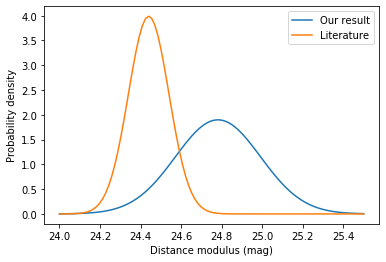

Z score: 1.47
p-value = 0.142
The two estimates are consistent.


In [10]:
cep_modulus = 24.44
cep_modulus_error = 0.1

print("Cepheid distance modulus = {:.2f} +/- {:.2f}".format(cep_modulus, cep_modulus_error))
cep_distance = modulus_to_Mpc(cep_modulus)
cep_lower68 = modulus_to_Mpc(cep_modulus - cep_modulus_error)
cep_upper68 = modulus_to_Mpc(cep_modulus + cep_modulus_error)
print("Cepheid distance = {:.3f} Mpc    |     68% CI: ({:.3f}, {:.3f}) Mpc".
      format(cep_distance, cep_lower68, cep_upper68))

# plot the two estimates' probability density
x = np.linspace(24, 25.5, 100)
y_result = st.norm.pdf(x, loc=modulus, scale=modulus_error)
y_theory = st.norm.pdf(x, loc=cep_modulus, scale=cep_modulus_error)
plt.figure()
plt.plot(x, y_result, label="Our result")
plt.plot(x, y_theory, label="Literature")
plt.legend(loc="upper right")
plt.xlabel("Distance modulus (mag)")
plt.ylabel("Probability density")
plt.show()

# HYPOTHESIS TESTING

# we may consider that the two estimates are consistent by testing whether their difference is consistent with zero

# we decide a significance level 5%
a = 0.05

# take the difference and its error (using propagation theory)
difference = (modulus - cep_modulus)
difference_error = (modulus_error ** 2.0 + cep_modulus_error ** 2.0) ** 0.5

# assuming normal distribution for the sample mean and the Cepheid estimate...
# their difference will also be normally distributed and we can use the Z-score to get a p-value
Z_score = difference / difference_error
print("Z score: {:.3g}".format(Z_score))
p_value = 2 * st.norm.cdf(-abs(Z_score))
print("p-value = {:.3f}".format(p_value))
if p_value < a:
    print("The two estimates are not consistent.")
else:
    print("The two estimates are consistent.")

## (d) From the distance estimate, calculate the absolute magnitudes of M31 GCs. Check if they follow the same distribution as the absolute magnitude of Milky Way GCs.

Use two methods. The 2-sample K-S statistic (`scipy.stats.ks_2samp`) and Wilcoxon rank-sum (`scipy.stats.ranksums`) method.

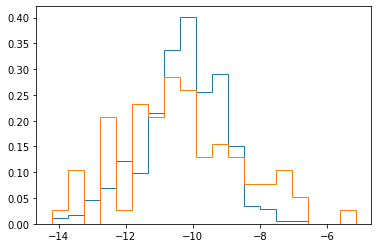

K-S 2-sample test
  Statistic:  0.135
  p-value  :  0.163
Wilcoxon rank-sum
  Statistic:  0.625
  p-value  :  0.532


In [11]:
absolute_M31 = apparent_M31 - modulus

# Looking at the distributions
x_min = min(min(absolute_M31), min(absolute_MWG))
x_max = max(max(absolute_M31), max(absolute_MWG))
bins = np.linspace(x_min, x_max, 20)
plt.hist(absolute_M31, bins=bins, density=True, histtype="step")
plt.hist(absolute_MWG, bins=bins, density=True, histtype="step")
plt.show()

print("K-S 2-sample test")
statistic, pvalue = st.ks_2samp(absolute_M31, absolute_MWG)
print("  Statistic:  {:.3g}".format(statistic))
print("  p-value  :  {:.3g}".format(pvalue))

print("Wilcoxon rank-sum")
statistic, pvalue = st.ranksums(absolute_M31, absolute_MWG)
print("  Statistic:  {:.3g}".format(statistic))
print("  p-value  :  {:.3g}".format(pvalue))

# Extra credit: normal approximation of Poisson distributions

It is known that the normal distribution is a good approximation of Poisson distribution when the parameter $\lambda$ is large.

1. Can you quantify this claim using sampling and hypothesis testing? Choose a sample size $N$ and some $\lambda$ values.

2. Do the results depend on the sample size?

3. Do the results depend on the testing method?

For l=0.5
  SW: p-value = 4.35e-39
  KS: p-value = 1.9e-121
For l=3
  SW: p-value = 5.13e-19
  KS: p-value = 5.39e-22
For l=10
  SW: p-value = 1.61e-08
  KS: p-value = 9.47e-06
For l=30
  SW: p-value = 8.97e-05
  KS: p-value = 0.00201


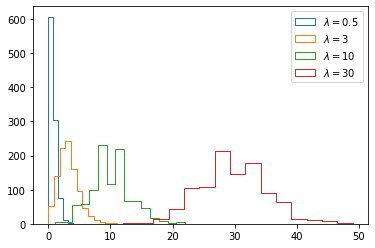

In [12]:
plt.figure()
sample_size = 1000
poisson_means_to_test = [0.5, 3, 10, 30]
for poisson_mean in poisson_means_to_test:
    sample = st.poisson.rvs(poisson_mean, size=sample_size)
    statistic, pvalue = st.shapiro(sample)
    print("For l={:.3g}".format(poisson_mean))
    print("  SW: p-value = {:.3g}".format(pvalue))
    
    norm_cdf = st.norm(loc=poisson_mean, scale=poisson_mean ** 0.5).cdf
    statistic, pvalue = st.kstest(sample, norm_cdf)
    print("  KS: p-value = {:.3g}".format(pvalue))
    
    nbins = min(15, max(sample) - min(sample) + 1)
    plt.hist(sample, bins=nbins, label=r"$\lambda = {:.2g}$".format(poisson_mean), histtype="step")
plt.legend()
plt.show()